# Assignment 6 - Feb13th, 2018

In this notebook, Bayesian modeling is applied to the auto price data.

In [5]:
getwd()
# Change the working directory 
setwd("/Users/duygusonmez/Desktop/DataScience410/Lecture1/")

# Read the csv file
read.auto = function(file = 'Automobile price data _Raw_.csv'){
  ## Read the csv file
  auto.price <- read.csv(file, header = TRUE, 
                      stringsAsFactors = FALSE)

  ## Coerce some character columns to numeric
  numcols <- c('price', 'bore', 'stroke', 'horsepower', 'peak.rpm')
  auto.price[, numcols] <- lapply(auto.price[, numcols], as.numeric)

  ## Remove cases or rows with missing values. In this case we keep the 
  ## rows which do not have nas. 
  auto.price[complete.cases(auto.price), ]
}
auto.price = read.auto()
str(auto.price)
head(auto.price)

[1] "/Users/duygusonmez/Desktop/DataScience410/Lecture1"

Warning message in lapply(auto.price[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(auto.price[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(auto.price[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(auto.price[, numcols], as.numeric):
“NAs introduced by coercion”Warning message in lapply(auto.price[, numcols], as.numeric):
“NAs introduced by coercion”

'data.frame':	195 obs. of  26 variables:
 $ symboling        : int  3 3 1 2 2 2 1 1 1 2 ...
 $ normalized.losses: chr  "?" "?" "?" "164" ...
 $ make             : chr  "alfa-romero" "alfa-romero" "alfa-romero" "audi" ...
 $ fuel.type        : chr  "gas" "gas" "gas" "gas" ...
 $ aspiration       : chr  "std" "std" "std" "std" ...
 $ num.of.doors     : chr  "two" "two" "two" "four" ...
 $ body.style       : chr  "convertible" "convertible" "hatchback" "sedan" ...
 $ drive.wheels     : chr  "rwd" "rwd" "rwd" "fwd" ...
 $ engine.location  : chr  "front" "front" "front" "front" ...
 $ wheel.base       : num  88.6 88.6 94.5 99.8 99.4 ...
 $ length           : num  169 169 171 177 177 ...
 $ width            : num  64.1 64.1 65.5 66.2 66.4 66.3 71.4 71.4 71.4 64.8 ...
 $ height           : num  48.8 48.8 52.4 54.3 54.3 53.1 55.7 55.7 55.9 54.3 ...
 $ curb.weight      : int  2548 2548 2823 2337 2824 2507 2844 2954 3086 2395 ...
 $ engine.type      : chr  "dohc" "dohc" "ohcv" "ohc" ...
 $ num.o

symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,⋯,engine.size,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,⋯,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,⋯,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,164,audi,gas,std,four,sedan,fwd,front,99.8,⋯,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
2,164,audi,gas,std,four,sedan,4wd,front,99.4,⋯,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
2,?,audi,gas,std,two,sedan,fwd,front,99.8,⋯,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


### 1. Compare the difference of the Bayesian estimate of the mean of log of auto price stratified by aspiration

In [3]:
table(auto.price$aspiration)


  std turbo 
  159    36 

In [27]:
autos.std <- auto.price[auto.price$aspiration == 'std',]
autos.turbo <- auto.price[auto.price$aspiration == 'turbo',] 

First, the plotting function is created. 

In [7]:
plot.dists <- function(a, b, cols = c('pop_A', 'pop_B'), nbins = 20){
  dat = c(a,b)
  maxs = max(dat, na.rm = TRUE)
  mins = min(dat, na.rm = TRUE)
  breaks = seq(maxs, mins, length.out = (nbins + 1))
  par(mfrow = c(2, 1))
  hist(a, breaks = breaks, main = paste('Histogram of', cols[1]), xlab = cols[1])
  abline(v = mean(a), lwd = 4, col = 'red')
  hist(b, breaks = breaks, main = paste('Histogram of', cols[2]), xlab = cols[2])
  abline(v = mean(b), lwd = 4, col = 'red')
  par(mfrow = c(1, 1))
}

We will compare the posterior distribution of the log prices of cars with standart aspiration to the log prices of turbo cars. As a first step, we will compute and evaluate Bayesian models for the mean log(Price) using a subset of just 25 observations.

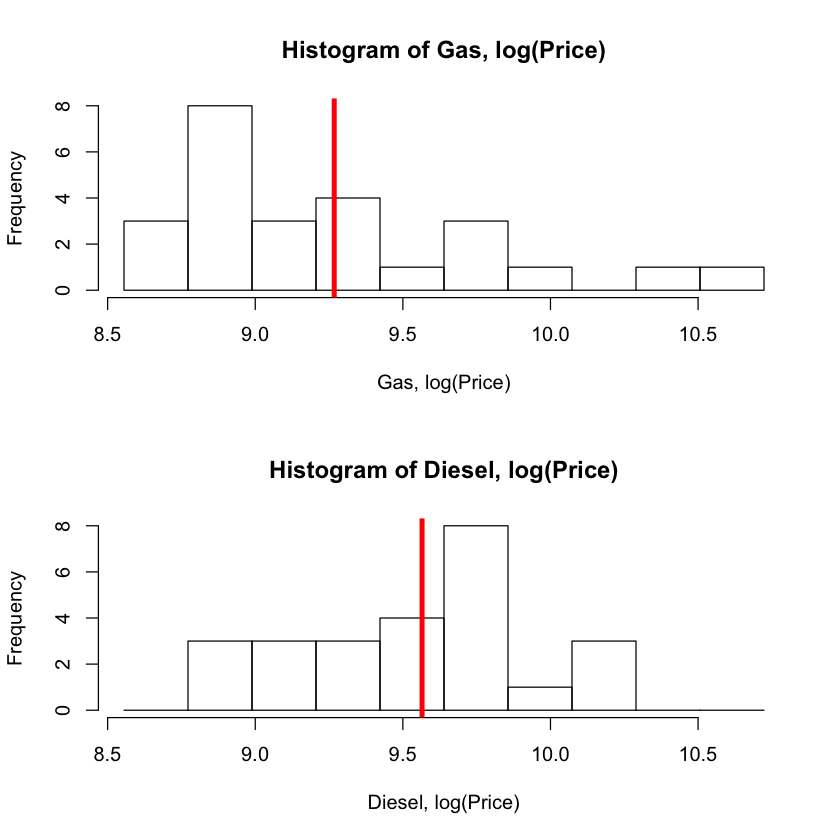

In [11]:
library(HistData)
require(dplyr)

numSamps = 25 
std.sampled = auto.price %>% filter(aspiration == 'std') %>% sample_n(numSamps)

std.sampled.log.prices = log(std.sampled$price)

numSamps = 25 
turbo.sampled = auto.price %>% filter(aspiration == 'turbo') %>% sample_n(numSamps)

turbo.sampled.log.prices = log(turbo.sampled$price)

plot.dists(std.sampled.log.prices, turbo.sampled.log.prices, cols = c('Std, log(Price)', 'Turbo, log(Price)'), nbins = 10)

To perform this analysis, we need to select a prior distribution and compute the likelihood. We will use a Normal likelihood for these data.

In [14]:
posterior = function(prior, like){
    post = prior * like  # Compute the product of the probabilities
    post / sum(post) # Normalize and return
}

plot.post = function(prior, like, post, x){
    maxy = max(c(prior, like, post))
    plot(x, like, , lty = 1, ylim = c(0.0, maxy), 
         ylab = 'Density', xlab = 'Parameter value',
         main = 'Density of prior, likelihood, posterior',
         lwd = 2, col = 'green')
    lines(x, prior, lty = 2, lwd = 2, col = 'blue')    
    lines(x, post, lty = 1, lwd = 2, col = 'red')
    legend('topright', c('likelihood', 'prior', 'posterior'), 
    lty=1, col=c('green', 'blue', 'red'), bty='n', cex=1.0)
    
    cat(' Maximum of prior density =', round(x[which.max(prior)], 3), '\n',
        'Maximum likelihood =', round(x[which.max(like)], 3), '\n',
         'MAP =', round(x[which.max(post)], 3))
}

We will only estimate the posterior distribution of the mean. We will use a fixed emperical estimate of the standard deviation.

 Mean = 9.267527 Standard deviation = 0.5411936 
 Maximum of prior density = 9.001 
 Maximum likelihood = 9.267 
 MAP = 9.267

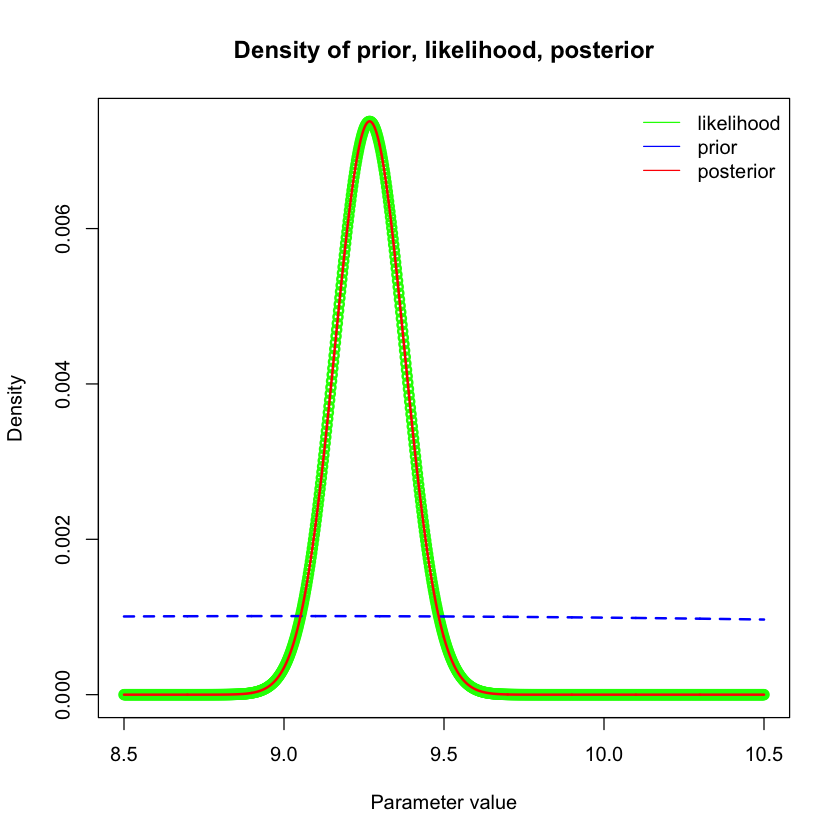

In [19]:
N = 1000 
p = seq(8.5, 10.5, length = N) 
mean.std.sampled.log.prices = round(mean(std.sampled.log.prices))

std.sampled.log.prices = sort(std.sampled.log.prices, decreasing = FALSE)
pp = dnorm(p, mean = mean.std.sampled.log.prices, sd = 5) ## start with a fairly broad prior
pp = pp / sum(pp)

comp.like = function(p, x){
    l = rep(0, length = length(p))
    sigmaSqr = sd(x)^2
    xBar = mean(x)
    cat(' Mean =', xBar, 'Standard deviation =', sqrt(sigmaSqr), '\n')
    n = length(x)
#    l = sapply(p, function(u) dnorm(u, mean = xBar, sd = sigmaSqr))
    l = sapply(p, function(u) exp(- n* (xBar - u)^2 / (2 * sigmaSqr)))
    l / sum(l) # Normalize and return
}

    
like.std = comp.like(p, std.sampled.log.prices)

post.std = posterior(pp, like.std)
plot.post(pp, like.std, post.std, p)

Now, we will calculate the posterior distribution of mean of the log(Price) of turbo autos.

 Mean = 9.56507 Standard deviation = 0.4000589 
 Maximum of prior density = 9.001 
 Maximum likelihood = 9.565 
 MAP = 9.565

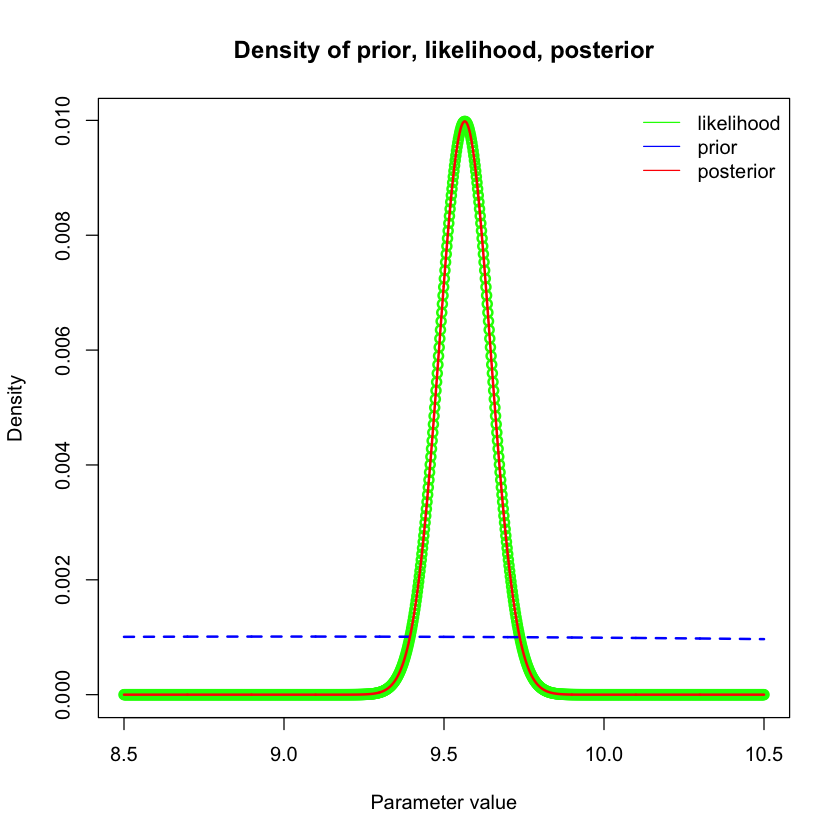

In [22]:
like.turbo = comp.like(p, turbo.sampled.log.prices)

post.turbo = posterior(pp, like.turbo)
plot.post(pp, like.turbo, post.turbo, p)

To compare the posterior distributions of the mean of log(Price) of autos with standart aspiration to the mean of log(Price) of turbo autos, we compute and compare the confidence intervals.

In [24]:
plot.ci = function(p, post, nSamps, qs){
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samps = sample(p, size = nSamps, replace = TRUE, prob = post)
    ci = quantile(samps, probs = qs) # compute the quantiles
    
    ## Plot the density with the credible interval
    interval = qs[2] - qs[1]
    title = paste('Posterior density with', interval, 'credible interval')
    plot(p, post, , typ = 'l', ylab = 'Density', xlab = 'Parameter value',
         main = title, lwd = 2, col = 'blue')
    abline(v = ci[1], col = 'red', lty = 2, lwd = 2)
    abline(v = ci[2], col = 'red', lty = 2, lwd = 2)
    cat('The', interval, 'Credible interval is', 
        round(ci[1], 2), 'to', round(ci[2], 2))
    }

The 0.95 Credible interval is 9.05 to 9.48

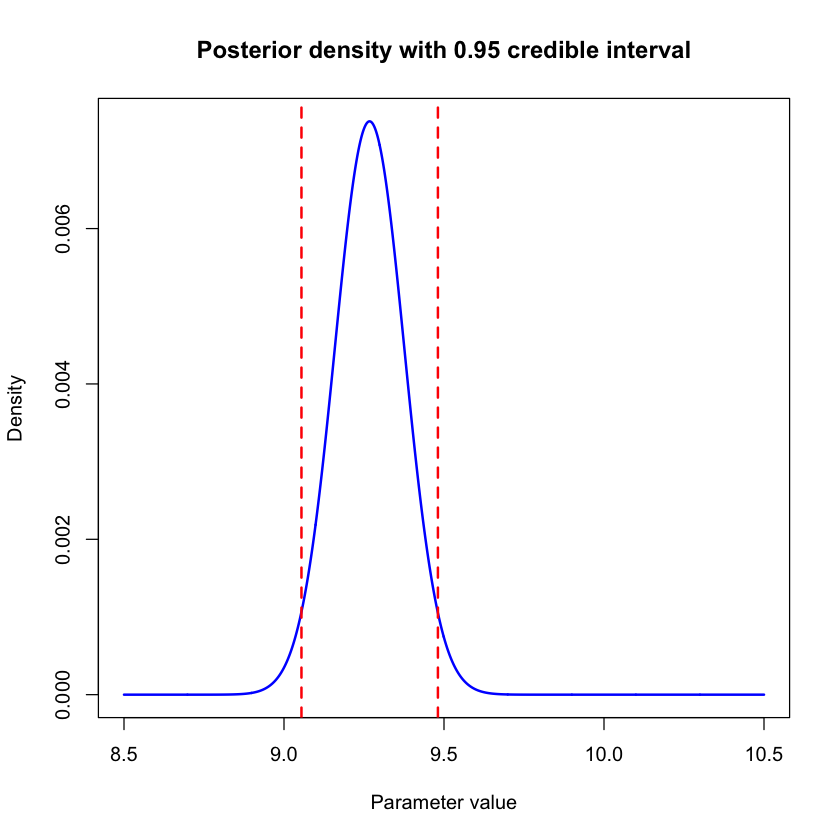

In [25]:
nSamps = 100000
qs = c(0.025, 0.975)
plot.ci(p, post.std, nSamps, qs)

Next, compute and plot the posterior distribution and CIs of the mean of the log(Price) of turbo autos.

The 0.95 Credible interval is 9.41 to 9.72

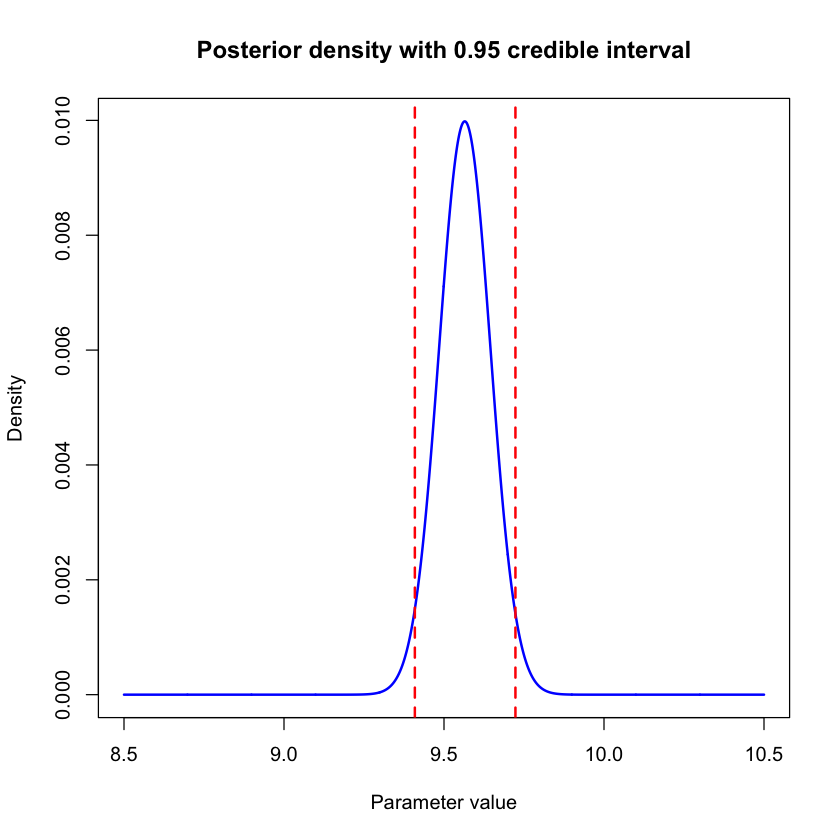

In [26]:
plot.ci(p, post.turbo, nSamps, qs)

### Comparison with the results of t-test and the bootstrap resampled distribution of the mean that were obtained in previous assignments

* Although means of log(Price) for both aspiration types are close to each other, we could say that there is a remarkable difference in the distributions of the means. Credible interval of the mean for std autos is between 9.05 and 9.48 while it is between 9.41 and 9.72 for turbo autos.
* The distribution of means of log Price skews a bit to the right with the same standart deviation that we used for std autos. Beacause prices are relatively higher for turbo autos.
* Results conform to findings from t-test and bootsrap resampled distribution of the mean that were obtained in previous assignments. 

### 2. Compare the differences of the Bayesian estimate of the distribution of the log price of the autos grouped by body style (sedan vs wagon)

In [28]:
table(auto.price$body.style)


convertible     hardtop   hatchback       sedan       wagon 
          6           8          63          94          24 

As we know from the results of bootstrap and t-test that were performed last week, the distribution of the mean of log price of sedan and wagon autos overlap. We will apply bayesian estimate to see if we will get similar results. 

To perform this, subsets that consisted of 25 observations for both sedan and wagon autos were created. 

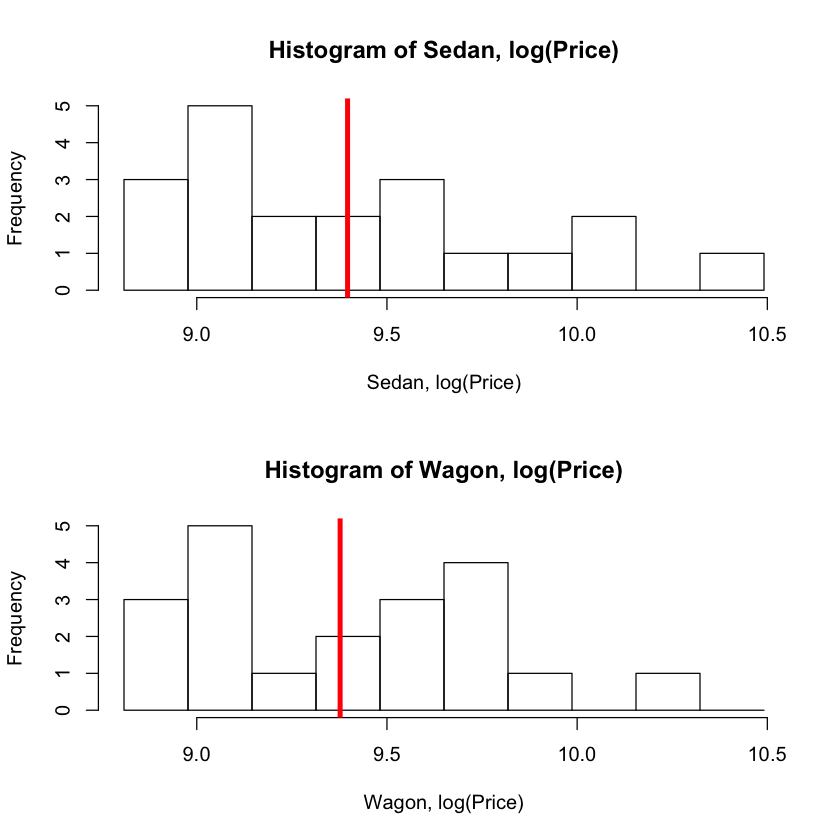

In [32]:
library(HistData)
require(dplyr)

numSamps = 20 
sedan.sampled = auto.price %>% filter(body.style == 'sedan') %>% sample_n(numSamps)

sedan.sampled.log.prices = log(sedan.sampled$price)

numSamps = 20 
wagon.sampled = auto.price %>% filter(body.style == 'wagon') %>% sample_n(numSamps)

wagon.sampled.log.prices = log(wagon.sampled$price)

plot.dists(sedan.sampled.log.prices, wagon.sampled.log.prices, cols = c('Sedan, log(Price)', 'Wagon, log(Price)'), nbins = 10)

As expected, means of the log(Price) of subsets of wagon and sedan autos are remarkably close to each other. 

Next, we will use Normal distribution for these data to perform the analysis and compute the likelihood. 

 Mean = 9.396489 Standard deviation = 0.4530951 
 Maximum of prior density = 9.001 
 Maximum likelihood = 9.397 
 MAP = 9.397

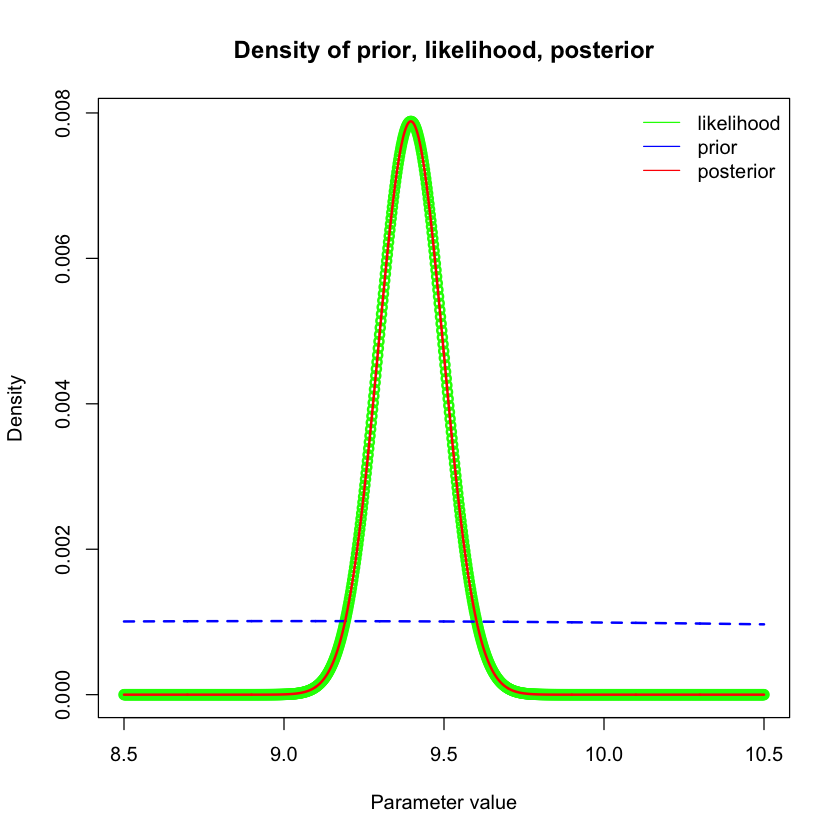

In [43]:
N = 1000 
p = seq(8.5, 10.5, length = N) 
mean.sedan.sampled.log.prices = round(mean(sedan.sampled.log.prices))

sedan.sampled.log.prices = sort(sedan.sampled.log.prices, decreasing = FALSE)
pp = dnorm(p, mean = mean.std.sampled.log.prices, sd = 5) ## start with a fairly broad prior
pp = pp / sum(pp)

comp.like = function(p, x){
    l = rep(0, length = length(p))
    sigmaSqr = sd(x)^2
    xBar = mean(x)
    cat(' Mean =', xBar, 'Standard deviation =', sqrt(sigmaSqr), '\n')
    n = length(x)
#    l = sapply(p, function(u) dnorm(u, mean = xBar, sd = sigmaSqr))
    l = sapply(p, function(u) exp(- n* (xBar - u)^2 / (2 * sigmaSqr)))
    l / sum(l) # Normalize and return
}
    
like.sedan = comp.like(p, sedan.sampled.log.prices)

post.sedan = posterior(pp, like.sedan)
plot.post(pp, like.sedan, post.sedan, p)

We are going to do the same for wegan autos.

 Mean = 9.376876 Standard deviation = 0.3810438 
 Maximum of prior density = 9.001 
 Maximum likelihood = 9.377 
 MAP = 9.377

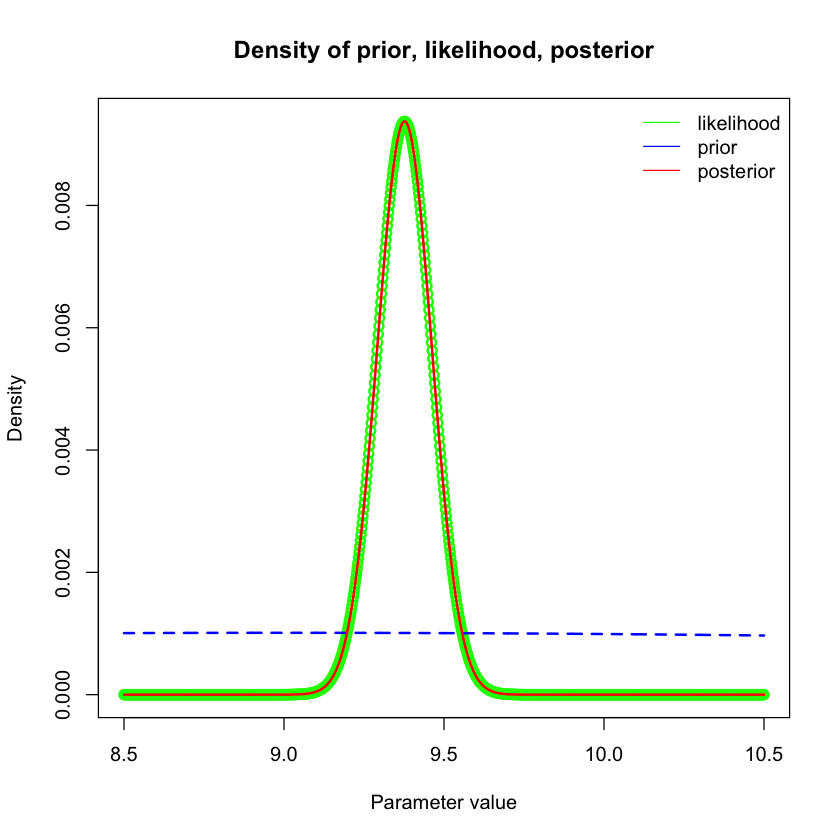

In [38]:
like.wagon = comp.like(p, wagon.sampled.log.prices)

post.wagon = posterior(pp, like.wagon)
plot.post(pp, like.wagon, post.wagon, p)

Then we compute the confidence intervals to compare the posterior distributions of the mean of log(Price) of sedan and wagon autos. 

The 0.95 Credible interval is 9.2 to 9.6

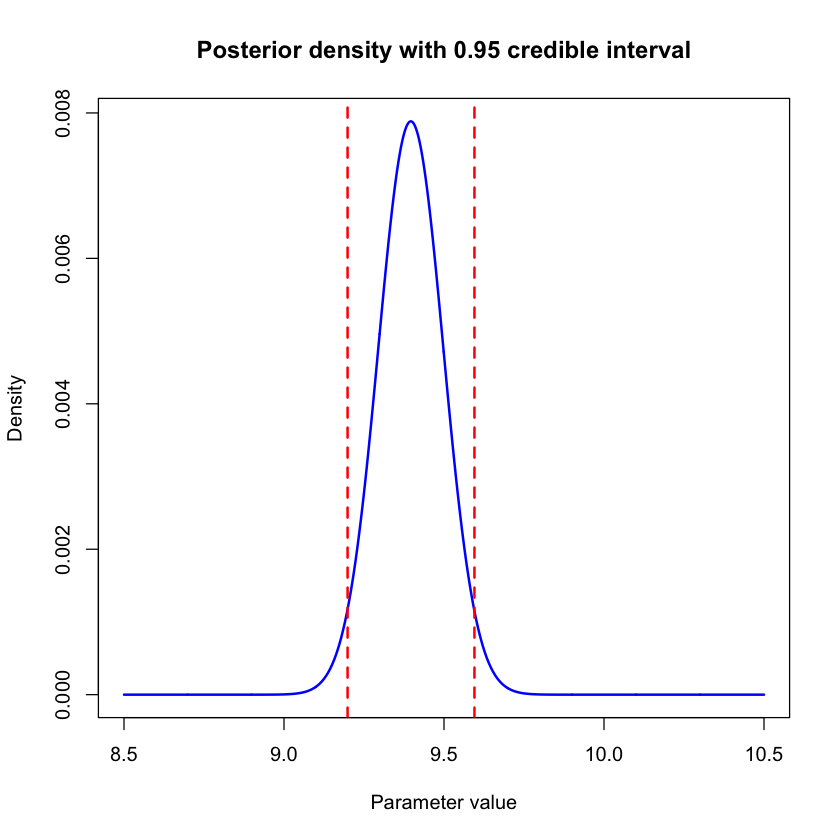

In [35]:
nSamps = 100000
qs = c(0.025, 0.975)
plot.ci(p, post.sedan, nSamps, qs)

The 0.95 Credible interval is 9.21 to 9.54

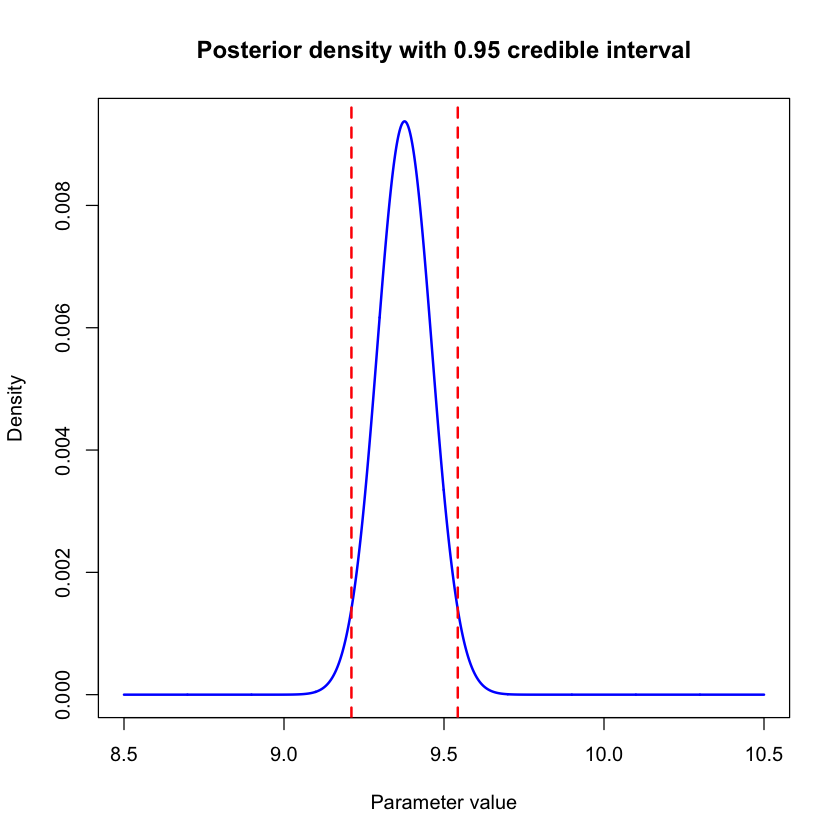

In [39]:
nSamps = 100000
qs = c(0.025, 0.975)
plot.ci(p, post.wagon, nSamps, qs)

### Comparison with the results of t-test and the bootstrap resampled distribution of the mean that were obtained in previous assignments

* There is a significant overlap between distributions of means of log price of sedan and wagon autos. 
* Autos with sedan and wagon body style have a similar range of price. 
* Results conform to findings from t-test and bootsrap resampled distribution of the mean that were obtained in previous assignments.

### Compare the differences of the Bayesian estimate of the distribution of the log price of the autos grouped by body style (hatcback vs wagon)

First we will generate subsets that consisted of 25 observations for both hatchback and wagon autos. As we know from the results of bootstrap and t-test, the distribution of the means of log price of hatchback and wagon autos don't overlap. We will see if we get similar results with the bayesian estimate.

Subsets that consisted of 25 observations for both hatchback and wagon autos were created.

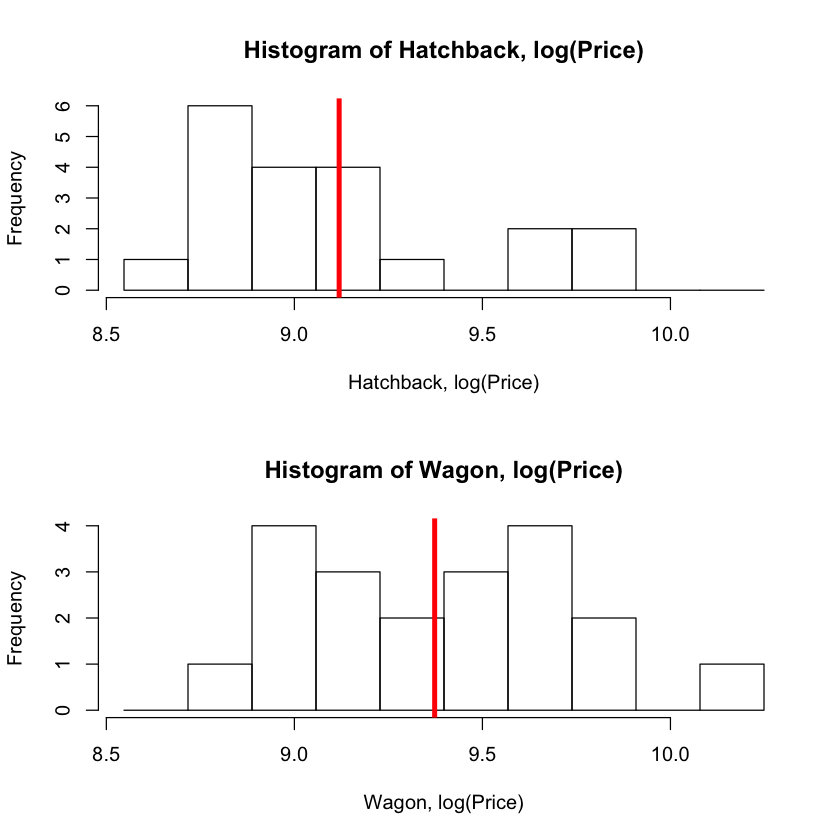

In [40]:
library(HistData)
require(dplyr)

numSamps = 20 
hatchback.sampled = auto.price %>% filter(body.style == 'hatchback') %>% sample_n(numSamps)

hatchback.sampled.log.prices = log(hatchback.sampled$price)

numSamps = 20 
wagon.sampled = auto.price %>% filter(body.style == 'wagon') %>% sample_n(numSamps)

wagon.sampled.log.prices = log(wagon.sampled$price)

plot.dists(hatchback.sampled.log.prices, wagon.sampled.log.prices, cols = c('Hatchback, log(Price)', 'Wagon, log(Price)'), nbins = 10)

As expected, there is a significant difference between means of the log(Price) of subsets of hatchback and sedan autos.

We will use normal distribution to perform analysis and calculate the posterior likelihood. 

 Mean = 9.119047 Standard deviation = 0.3683157 
 Maximum of prior density = 9.001 
 Maximum likelihood = 9.119 
 MAP = 9.119

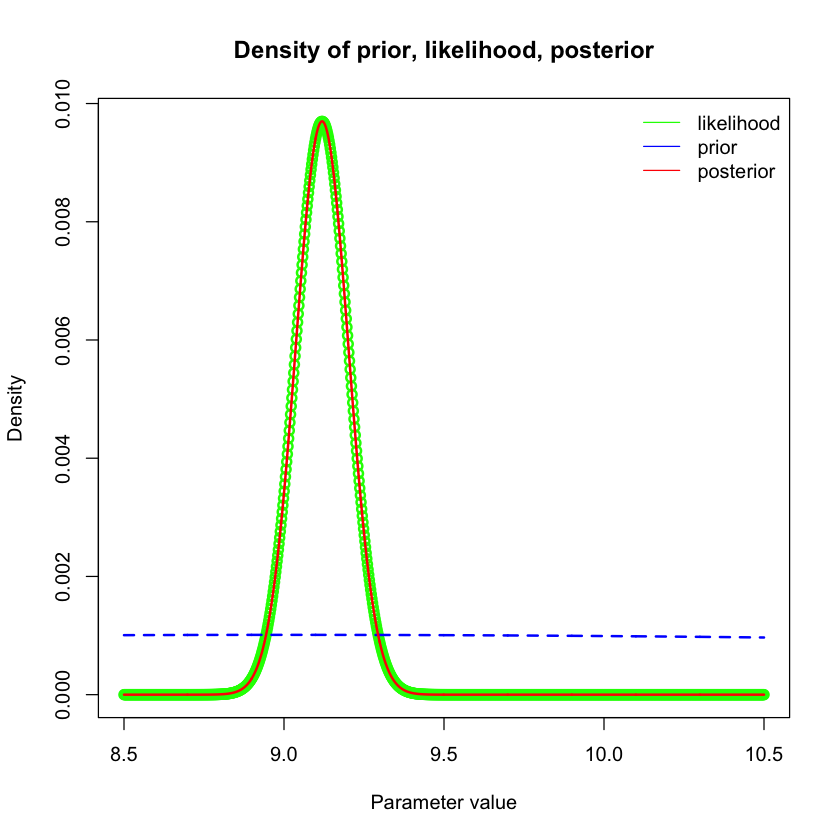

In [45]:
N = 1000 
p = seq(8.5, 10.5, length = N) 
mean.hatchback.sampled.log.prices = round(mean(hatchback.sampled.log.prices))

hatchback.sampled.log.prices = sort(hatchback.sampled.log.prices, decreasing = FALSE)
pp = dnorm(p, mean = mean.hatchback.sampled.log.prices, sd = 5) ## start with a fairly broad prior
pp = pp / sum(pp)

comp.like = function(p, x){
    l = rep(0, length = length(p))
    sigmaSqr = sd(x)^2
    xBar = mean(x)
    cat(' Mean =', xBar, 'Standard deviation =', sqrt(sigmaSqr), '\n')
    n = length(x)
#    l = sapply(p, function(u) dnorm(u, mean = xBar, sd = sigmaSqr))
    l = sapply(p, function(u) exp(- n* (xBar - u)^2 / (2 * sigmaSqr)))
    l / sum(l) # Normalize and return
}
    
like.hatchback = comp.like(p, hatchback.sampled.log.prices) 

post.hatchback = posterior(pp, like.hatchback)
plot.post(pp, like.hatchback, post.hatchback, p) 

We are going to do the same for wegan autos.

 Mean = 9.373039 Standard deviation = 0.3855506 
 Maximum of prior density = 9.001 
 Maximum likelihood = 9.373 
 MAP = 9.373

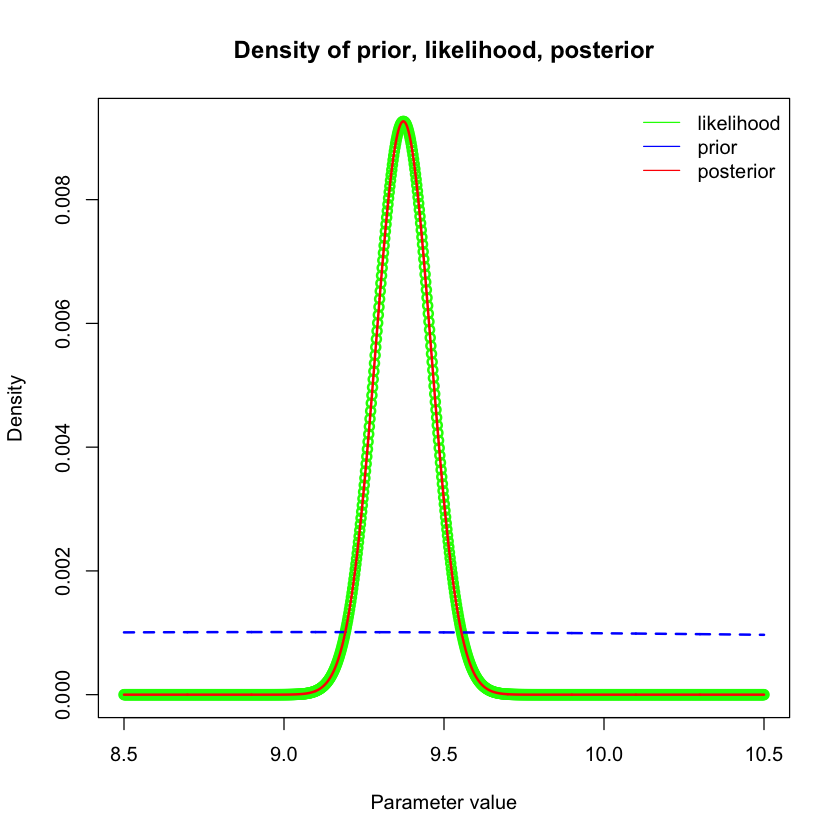

In [46]:
like.wagon = comp.like(p, wagon.sampled.log.prices)

post.wagon = posterior(pp, like.wagon)
plot.post(pp, like.wagon, post.wagon, p)

Then we compute the confidence intervals to compare the posterior distributions of the means of log(Price) of hatchback and wagon autos.

The 0.95 Credible interval is 8.96 to 9.28

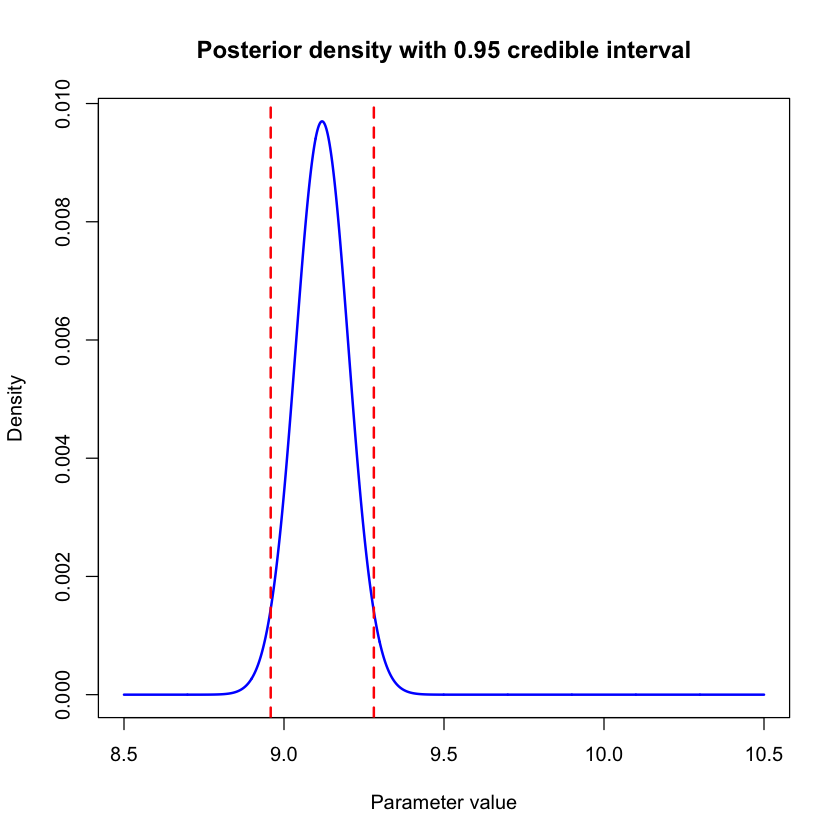

In [47]:
nSamps = 100000
qs = c(0.025, 0.975)
plot.ci(p, post.hatchback, nSamps, qs)

The 0.95 Credible interval is 9.2 to 9.54

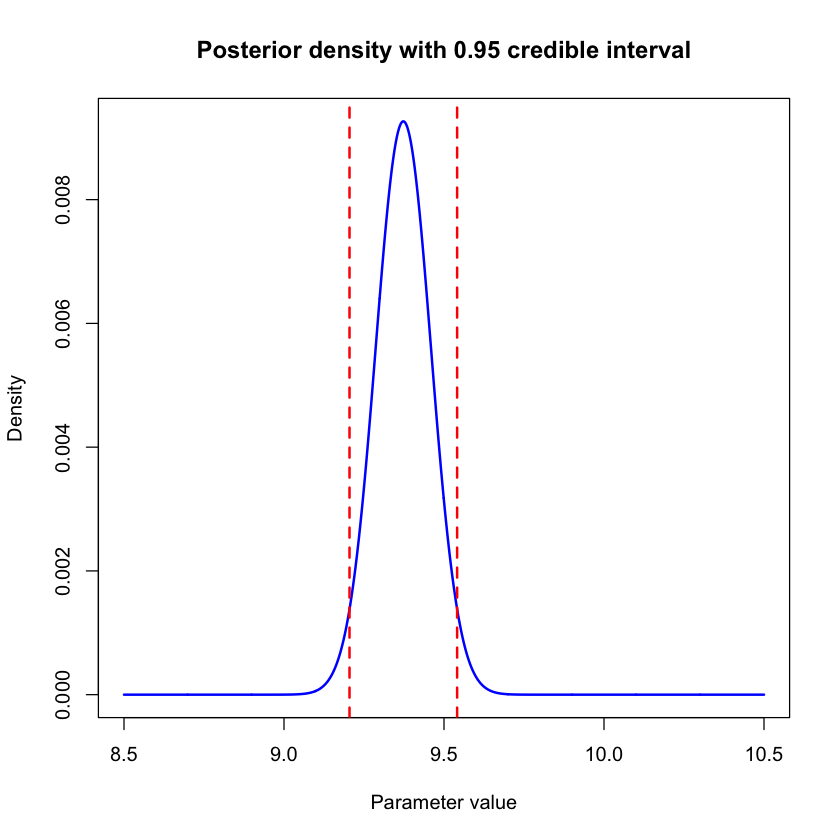

In [48]:
nSamps = 100000
qs = c(0.025, 0.975)
plot.ci(p, post.wagon, nSamps, qs)

### Comparison with the results of t-test and the bootstrap resampled distribution of the mean that were obtained in previous assignments

* There is a remarkable difference in the distributions of the means of log(Price) for both body types. Credible interval of the mean for hatchback autos is between 8.96 and 9.28 while it is between 9.2 and 9.54 for wagon autos.
* Prices are relatively higher for wagon autos.
* Results conform to findings from t-test and bootsrap resampled distribution of the mean that were obtained in previous assignments. 